In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

from xgboost import XGBClassifier

In [2]:
df = pd.read_excel("data_modified_v1.xlsx")
df.head()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),service_used,payment_method_churn_rate,location_churn_rate,device_churn_rate
0,0,2,Jakarta,Mid End,1,1,0,0,0,0,Digital Wallet,70.005,1,106.816666,-6.2,4210.7,2,0.191067,0.26297,0.189591
1,1,2,Jakarta,High End,0,0,0,0,0,0,Pulsa,91.910,1,106.816666,-6.2,3511.3,0,0.452854,0.26297,0.418928
2,2,8,Jakarta,High End,0,0,1,0,1,1,Pulsa,129.545,1,106.816666,-6.2,6983.6,3,0.452854,0.26297,0.418928
3,3,28,Jakarta,High End,0,0,1,1,1,1,Pulsa,136.240,1,106.816666,-6.2,6503.9,4,0.452854,0.26297,0.418928
4,4,49,Jakarta,High End,0,1,1,0,1,1,Debit,134.810,1,106.816666,-6.2,6942.0,4,0.167098,0.26297,0.418928


In [3]:
df.drop(["Customer ID", "Latitude", "Longitude"], axis=1, inplace=True)
df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,CLTV (Predicted Thou. IDR),service_used,payment_method_churn_rate,location_churn_rate,device_churn_rate
0,2,Jakarta,Mid End,1,1,0,0,0,0,Digital Wallet,70.005,1,4210.7,2,0.191067,0.26297,0.189591
1,2,Jakarta,High End,0,0,0,0,0,0,Pulsa,91.910,1,3511.3,0,0.452854,0.26297,0.418928
2,8,Jakarta,High End,0,0,1,0,1,1,Pulsa,129.545,1,6983.6,3,0.452854,0.26297,0.418928
3,28,Jakarta,High End,0,0,1,1,1,1,Pulsa,136.240,1,6503.9,4,0.452854,0.26297,0.418928
4,49,Jakarta,High End,0,1,1,0,1,1,Debit,134.810,1,6942.0,4,0.167098,0.26297,0.418928


In [4]:
def encode_data(df):
    if df.dtype == "object":
        le = LabelEncoder()
        df = le.fit_transform(df)
    return df

In [5]:
df = df.apply(lambda x: encode_data(x))
df.head()

,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,CLTV (Predicted Thou. IDR),service_used,payment_method_churn_rate,location_churn_rate,device_churn_rate
0,2,1,2,1,1,0,0,0,0,2,70.005,1,4210.7,2,0.191067,0.26297,0.189591
1,2,1,0,0,0,0,0,0,0,3,91.910,1,3511.3,0,0.452854,0.26297,0.418928
2,8,1,0,0,0,1,0,1,1,3,129.545,1,6983.6,3,0.452854,0.26297,0.418928
3,28,1,0,0,0,1,1,1,1,3,136.240,1,6503.9,4,0.452854,0.26297,0.418928
4,49,1,0,0,1,1,0,1,1,1,134.810,1,6942.0,4,0.167098,0.26297,0.418928


In [6]:
fig = px.bar(df.corr()['Churn Label'].sort_values(ascending = False),
             color = 'value')
fig.show()

In [7]:
over = SMOTE(sampling_strategy=1)

X = df.drop(["Churn Label"], axis=1)
y = df["Churn Label"]

In [8]:
X, y = over.fit_resample(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8278, 16), (2070, 16), (8278,), (2070,))

In [10]:
def model(method, x_train, y_train, x_test, y_test):
    # Train the model
    method.fit(x_train, y_train)
    
    # Make predictions on test data and calculate confusion matrix
    predictions = method.predict(x_test)
    c_matrix = confusion_matrix(y_test, predictions)
    
    # Calculate label percentages and create label strings with counts and percentages
    percentages = (c_matrix / np.sum(c_matrix, axis=1)[:, np.newaxis]).round(2) * 100
    labels = [[f"{c_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
    labels = np.asarray(labels)
    
    # Plot confusion matrix with labeled counts and percentages
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    
    # Evaluate model performance and print results
    print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
    print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))

ROC AUC:  83.79%
Model accuracy:  83.77%
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1021
           1       0.85      0.82      0.84      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



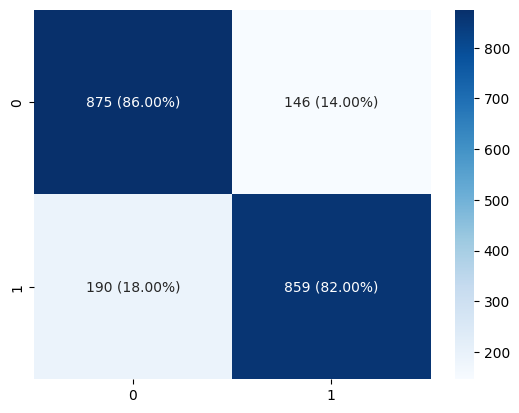

In [11]:
xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

model(xgb, X_train, y_train, X_test, y_test)

In [12]:
xgb = XGBClassifier()

param_grid = {
    'max_depth': [5, 6],
    'learning_rate': [0.1, 0.15],
    'n_estimators': [200, 250],
    'gamma': [0.2, 0.3],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 0.9],
}

grid_clf = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=3, n_jobs=1, verbose=1)
grid_clf.fit(X_train, y_train)

print(grid_clf.best_params_)
print(grid_clf.best_score_)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
{'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.8}
0.934159933172842


              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1021
           1       0.86      0.81      0.83      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



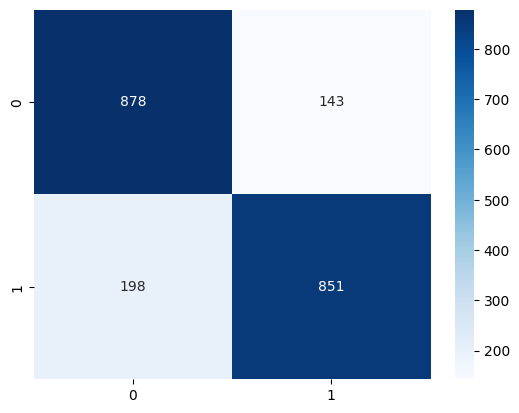

In [13]:
#roc auc score
roc_auc_score(y_test, grid_clf.predict(X_test))

#accuracy score
accuracy_score(y_test, grid_clf.predict(X_test))

# classification report
print(classification_report(y_test, grid_clf.predict(X_test)))

#confusion matrix
c_matrix = confusion_matrix(y_test, grid_clf.predict(X_test))

#plot confusion matrix
sns.heatmap(c_matrix, annot=True, fmt='', cmap='Blues')

#plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, grid_clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={roc_auc:.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()


In [14]:
# feature importance
importance = grid_clf.best_estimator_.feature_importances_
feature_imp = pd.Series(importance, index=X.columns).sort_values(ascending=False)
fig = px.bar(feature_imp, color=feature_imp, title='Feature Importance')
fig.show()